# Customer Lending Risk Classification

<br>
<br>

### Introduction

>This is a personal study made on credit dataset.
>The problem is binary classification, to classify bank customers as their lending ratings.

<br>

### Data Preprocessing
>First I've analysed the dataset by reading through the CSV.
>Checked for any unknown values, the data had no empty cells.
>Used label encoding

<br>

### Dataset Observations
>Examined the correlation matrix, this helped tweaking the bayesian network nodes.
>
>The target class is imbalanced, while there is 700 'good' credit samples,
>there is only 300 'bad' credit samples included.
>
>The data didn't have any null/NaN/? values.
>
>All data were categorical, while evaluation, I took that into account.
>
>The dataset was lack of any single females. This particular data must be gathered
>in case of any single female prediction need.

<br>

### Tested algorithms:
<ul>
<li> Categorical Naive Bayes </li> 
<li> DecisionTreeClassifier </li>
<li> GaussianNB </li>
<li> KNeighborsClassifier </li>
<li> LGBMClassifier </li>
<li> LinearDiscriminantAnalysis </li>
<li> LogisticRegression </li>
<li> RandomForestClassifier </li>
<li> Support Vector Classifier
<li> XGBClassifier </li>
<li> Bayesian  Network </li>
</ul>

In [176]:
from sklearn.naive_bayes import CategoricalNB
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

# PLotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model

# Algorithmns models to be compared
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from pgmpy.models import BayesianNetwork

In [177]:
train_data = pd.read_csv('C:/Users/Berkay/Desktop/train.csv')
test_data = pd.read_csv('C:/Users/Berkay/Desktop/test.csv')
all_data = train_data.append(test_data, ignore_index=True)
all_data.head()

,credit_history,purpose,employment,personal_status,property_magnitude,housing,job,own_telephone,class
0,critical/other existing credit,furniture/equipment,1<=X<4,male div/sep,real estate,rent,high qualif/self emp/mgmt,yes,bad
1,delayed previously,repairs,1<=X<4,male mar/wid,life insurance,own,skilled,none,bad
2,existing paid,new car,1<=X<4,male single,no known property,for free,skilled,yes,good
3,delayed previously,radio/tv,>=7,male single,car,own,skilled,none,good
4,critical/other existing credit,repairs,>=7,male single,no known property,for free,skilled,none,good


In [178]:
#Looking for any inconvenient values in all data
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   credit_history      1000 non-null   object
 1   purpose             1000 non-null   object
 2   employment          1000 non-null   object
 3   personal_status     1000 non-null   object
 4   property_magnitude  1000 non-null   object
 5   housing             1000 non-null   object
 6   job                 1000 non-null   object
 7   own_telephone       1000 non-null   object
 8   class               1000 non-null   object
dtypes: object(9)
memory usage: 70.4+ KB


In [179]:
from sklearn.preprocessing import LabelEncoder

encoded_train_data = train_data.apply( LabelEncoder().fit_transform )
encoded_test_data = test_data.apply( LabelEncoder().fit_transform )
encoded_all_data = all_data.apply( LabelEncoder().fit_transform )

correlation_matrix = encoded_all_data.corr()

print('- Correlations to credit risk:')
print(correlation_matrix['class'].sort_values().iloc[::-1])

fig = px.imshow(correlation_matrix, title='Data Correlations')
fig.show()

- Correlations to credit risk:
class                 1.000000
purpose               0.139263
personal_status       0.089535
property_magnitude    0.055529
own_telephone         0.036466
job                   0.032756
employment           -0.008932
housing              -0.019315
credit_history       -0.097054
Name: class, dtype: float64


In [180]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   credit_history      1000 non-null   object
 1   purpose             1000 non-null   object
 2   employment          1000 non-null   object
 3   personal_status     1000 non-null   object
 4   property_magnitude  1000 non-null   object
 5   housing             1000 non-null   object
 6   job                 1000 non-null   object
 7   own_telephone       1000 non-null   object
 8   class               1000 non-null   object
dtypes: object(9)
memory usage: 70.4+ KB


In [181]:
cat_cols = [col for col in train_data.columns if train_data[col].dtypes == 'O']

for col in cat_cols:
    print(train_data[col].value_counts(), "\n\n")

existing paid                     436
critical/other existing credit    228
delayed previously                 65
all paid                           39
no credits/all paid                32
Name: credit_history, dtype: int64 


radio/tv               211
new car                187
furniture/equipment    156
used car                87
business                75
education               38
other                   27
repairs                 19
Name: purpose, dtype: int64 


1<=X<4        267
>=7           207
4<=X<7        141
<1            136
unemployed     49
Name: employment, dtype: int64 


male single           438
female div/dep/mar    253
male mar/wid           72
male div/sep           37
Name: personal_status, dtype: int64 


car                  270
real estate          227
life insurance       182
no known property    121
Name: property_magnitude, dtype: int64 


own         566
rent        149
for free     85
Name: housing, dtype: int64 


skilled                      504
unsk

In [182]:
class_good_counts = all_data[all_data["class"]== 'good']["class"].value_counts()
class_bad_counts = all_data[all_data["class"]== 'bad']["class"].value_counts()

bar0 = go.Bar(
            x = class_good_counts.index.values,
            y = class_good_counts.values,
            name='Good credit',
            marker_color='turquoise')

bar1 = go.Bar(
            x = class_bad_counts.index.values,
            y = class_bad_counts.values,
            name='Bad credit',
            marker_color='#FF4365') # Radical Red

data = [bar0, bar1]
layout = go.Layout(
    yaxis=dict( title='Count' ),
    xaxis=dict( title='Credit Class Variable' ),
    title='Target Class Variable Distribution')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [172]:
df_good = all_data.loc[all_data["class"] == 'good']['employment'].values.tolist()
df_bad = all_data.loc[all_data["class"] == 'bad']['employment'].values.tolist()
df_age = all_data['employment'].values.tolist()

# Plot Good Credit
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    marker_color='turquoise',
    name="Good Credit")

# Plot Bad Credit
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    marker_color='#FF4365', # Radical Red
    name="Bad Credit",)

# Plot General Distribution
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker_color='darkblue'   
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribution'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Employment Distribution', bargap=0.04)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [173]:
# Housing Bar Chart
housing_good = all_data[all_data["class"]== 'good']["housing"].value_counts()
housing_bad = all_data[all_data["class"]== 'bad']["housing"].value_counts()

trace0 = go.Bar(
    x = housing_good.index.values,
    y = housing_good.values,
    marker_color='turquoise',
    name='Good Credit'
)

trace1 = go.Bar(
    x = housing_bad.index.values,
    y = housing_bad.values,
    marker_color='#FF4365', # Radical Red
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='housing-distribuition-bar')


In [174]:
# Job Bar Chart

job_good_counts = all_data[all_data['class']== 'good']['job'].value_counts()
job_bad_counts = all_data[all_data['class']== 'bad']['job'].value_counts()

trace0 = go.Bar(
    x = job_good_counts.index.values,
    y = job_good_counts.values,
    marker_color='turquoise',
    name='Good Credit')

trace1 = go.Bar(
    x = job_bad_counts.index.values,
    y = job_bad_counts.values,
    marker_color='#FF4365', # Radical Red
    name='Bad Credit')

data = [trace0, trace1]

layout = go.Layout(title='Job Distribution')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='job-distribution-bar')

In [156]:
## Data Preprocessing and Feature Engineering

In [192]:
try:
    train_y = encoded_train_data['class']
    test_y = encoded_test_data['class']
    del encoded_train_data['class']
    del encoded_test_data['class']
    train_X = encoded_train_data
    test_X = encoded_test_data
    del encoded_train_data
    del encoded_test_data
except KeyError:
    pass

In [195]:
# Predict Train Data
train_data_predictions = model.predict(train_X)

  0%|          | 0/663 [00:00<?, ?it/s]

In [196]:
print(metrics.classification_report(train_data_predictions, train_y))

              precision    recall  f1-score   support

           0       0.34      0.62      0.44       128
           1       0.92      0.77      0.84       672

    accuracy                           0.75       800
   macro avg       0.63      0.70      0.64       800
weighted avg       0.82      0.75      0.77       800



In [32]:
model.fit(test_X, test_y)
train_data_predictions = model.predict(train_X)
print(metrics.classification_report(train_data_predictions, train_y))

              precision    recall  f1-score   support

           0       0.37      0.50      0.43       174
           1       0.85      0.77      0.80       626

    accuracy                           0.71       800
   macro avg       0.61      0.63      0.62       800
weighted avg       0.74      0.71      0.72       800



LGR: 0.987657 (0.008952)
LDA: 0.985887 (0.006998)
KNN: 0.883419 (0.016949)
CART: 0.712141 (0.054158)
CNB: 0.906397 (0.025850)
GNB: 0.948797 (0.011535)
CNB: 0.906397 (0.025850)
RF: 0.842788 (0.015857)
SVM: 0.985918 (0.015278)
XGBM: 0.789924 (0.058701)
LGBM: 0.812840 (0.042419)


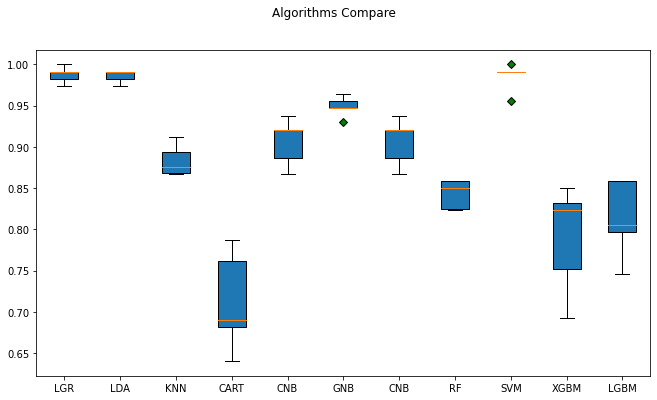

In [35]:
seed = 7

# prepare models
models = []

models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CNB', CategoricalNB()))
models.append(('GNB', GaussianNB()))
models.append(('CNB', CategoricalNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))


# Evaluating each model
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, train_X, train_y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.show()

CNB: 0.720295 (0.111263)
CART: 0.715513 (0.095344)
GNB: 0.708432 (0.123203)
KNN: 0.696764 (0.123660)
LGBM: 0.733876 (0.124176)
LDA: 0.712713 (0.103181)
LGR: 0.705675 (0.102721)
RF: 0.703120 (0.129184)
SVM: 0.707671 (0.124680)
XGBM: 0.713457 (0.137880)


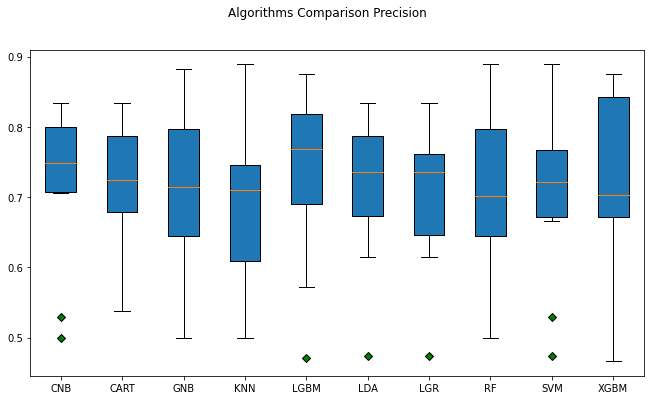

CNB: 0.827155 (0.133413)
CART: 0.663600 (0.135043)
GNB: 0.847711 (0.144095)
KNN: 0.814832 (0.144443)
LGBM: 0.807091 (0.132212)
LDA: 0.870239 (0.108025)
LGR: 0.877931 (0.114082)
RF: 0.823785 (0.187876)
SVM: 0.913783 (0.082964)
XGBM: 0.740631 (0.153480)


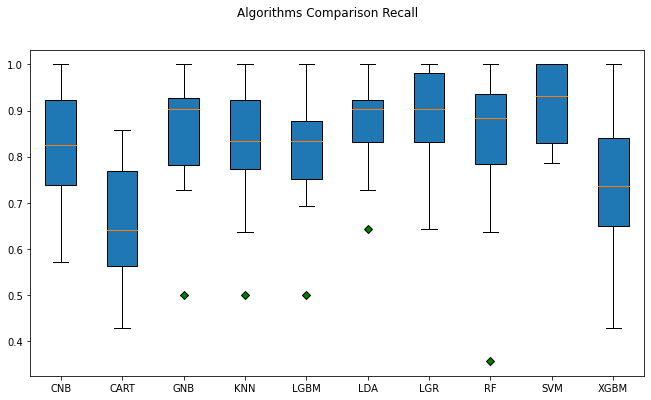

CNB: 0.665000 (0.114127)
CART: 0.605000 (0.101119)
GNB: 0.665000 (0.122577)
KNN: 0.645000 (0.129325)
LGBM: 0.675000 (0.130863)
LDA: 0.675000 (0.090139)
LGR: 0.670000 (0.095394)
RF: 0.660000 (0.135647)
SVM: 0.685000 (0.111915)
XGBM: 0.625000 (0.134629)


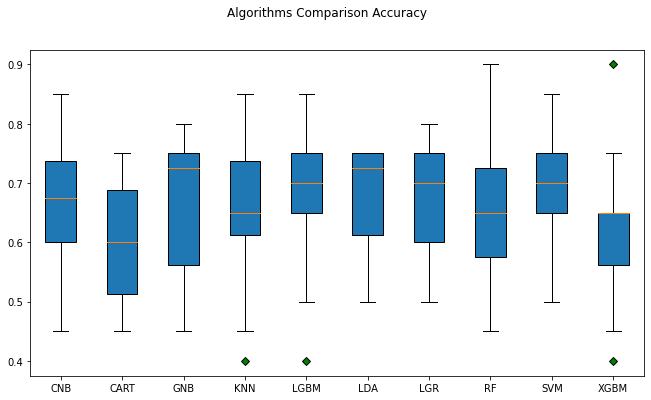

CNB: 0.760238 (0.094101)
CART: 0.661535 (0.091643)
GNB: 0.762014 (0.108727)
KNN: 0.743911 (0.113688)
LGBM: 0.760119 (0.110058)
LDA: 0.775252 (0.078988)
LGR: 0.773983 (0.081549)
RF: 0.741093 (0.139765)
SVM: 0.789234 (0.087380)
XGBM: 0.714353 (0.121071)


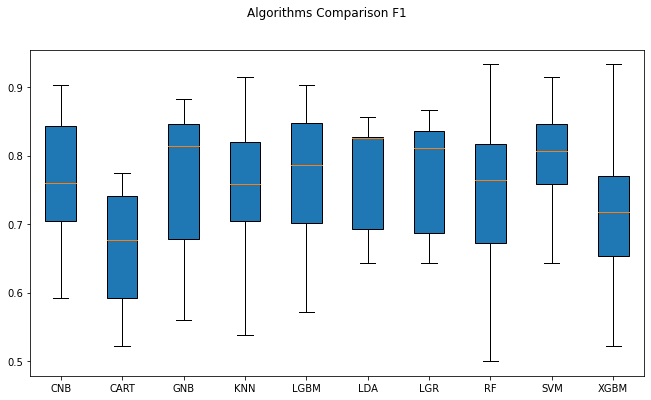

CNB: 0.639079 (0.131952)
CART: 0.563987 (0.090058)
GNB: 0.609525 (0.160346)
KNN: 0.606919 (0.135082)
LGBM: 0.638326 (0.147745)
LDA: 0.608510 (0.117194)
LGR: 0.603875 (0.117500)
RF: 0.616598 (0.150783)
SVM: 0.627723 (0.148297)
XGBM: 0.648795 (0.133012)


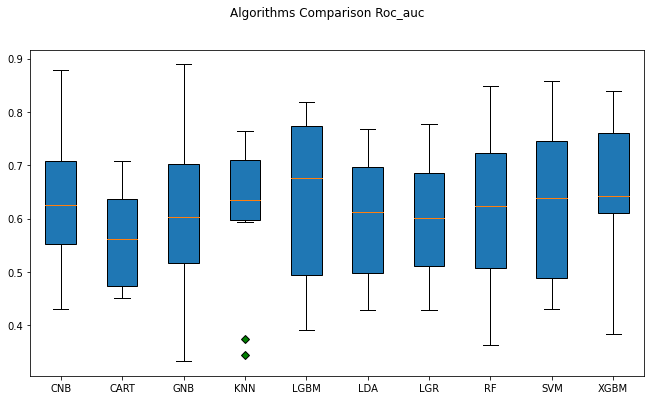

In [137]:
seed = 7

# prepare models
models = []

models.append(('CNB', CategoricalNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LGR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))


# Evaluating each model

scorings = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']

for plot_index, scoring in enumerate(scorings):
    
    results = []
    names = []
    for name, model in models:

            kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
            cv_results = cross_val_score(model, test_X, test_y, cv=kfold, scoring=scoring)
            results.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
            print(msg)

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Algorithms Comparison ' + scoring.capitalize())
    ax = fig.add_subplot(111)
    green_diamond = dict(markerfacecolor='g', marker='D')
    plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
    ax.set_xticklabels(names)
    plt.show()

In [124]:
# SVM, LGR, LDA, Naive Bayes seems to be best for the primitive comparison.

Primitive error evaluation accuracy score: 0.7025
Test predict accuracy score:  0.705 

Confusion Matrix: 
 [[  9  57]
 [  2 132]] 

Classification report according to Test prediction: 
               precision    recall  f1-score   support

           0       0.82      0.14      0.23        66
           1       0.70      0.99      0.82       134

    accuracy                           0.70       200
   macro avg       0.76      0.56      0.53       200
weighted avg       0.74      0.70      0.62       200



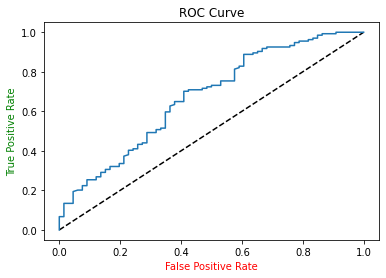

In [129]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

gnb = GaussianNB()

# Training with data
model = gnb.fit(train_X, train_y)

print("Primitive error evaluation accuracy score:", model.score(train_X, train_y))

y_predictions = model.predict(test_X)

print("Test predict accuracy score: ", accuracy_score(test_y, y_predictions),"\n")

print("Confusion Matrix: \n", confusion_matrix(test_y, y_predictions),"\n")

print("Classification report according to Test prediction: \n", classification_report(test_y, y_predictions))


# Proba
y_pred_prob = model.predict_proba(test_X)[:,1]

# ROC values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)

# ROC Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
plt.show()

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA


features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# Pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic_regression', LogisticRegression()))
model = Pipeline(estimators)

# Evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, train_X, train_y, cv=kfold)
print('Train mean results:', results.mean())

results = cross_val_score(model, test_X, test_y, cv=kfold)
print('Test mean results:', results.mean())

Train mean results: 0.70875
Test mean results: 0.635


In [190]:
# Bayesian Network


from sklearn import preprocessing
label = preprocessing.LabelEncoder()
train_data_encoded = pd.DataFrame()

for i in train_data.columns :
  train_data_encoded[i]=label.fit_transform(train_data[i])


model = BayesianNetwork()

for node in train_data.columns:
    model.add_node(node)

for node in train_data.columns:
    if node != 'class':
        model.add_edge('class', node)

model.add_edge('property_magnitude', 'housing')
model.add_edge('property_magnitude', 'job')
model.add_edge('housing', 'purpose')
#model.add_edge('housing', 'personal_status')
model.add_edge('job', 'employment')
model.add_edge('job', 'own_telephone')
model.add_edge('own_telephone', 'credit_history')

# Learning CPD
model.fit(train_data_encoded)

# Checking model and it's dependencies
model.check_model()

# Predictions
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)


print('Bayesian Network TRAIN Data Classification Report:'
print('metrics.classification_report(train_y, train_predictions), '\n')
print(metrics.classification_report(test_y, test_predictions))

print('Bayesian Network TEST Data Classification Report:')
metrics.accuracy_score(test_y, test_predictions)

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Bayesian Network TRAIN Data Classification Report:               precision    recall  f1-score   support

           0       0.62      0.34      0.44       234
           1       0.77      0.92      0.84       566

    accuracy                           0.75       800
   macro avg       0.70      0.63      0.64       800
weighted avg       0.73      0.75      0.72       800
 

              precision    recall  f1-score   support

           0       0.70      0.35      0.46        66
           1       0.74      0.93      0.82       134

    accuracy                           0.73       200
   macro avg       0.72      0.64      0.64       200
weighted avg       0.73      0.73      0.71       200

Bayesian Network TEST Data Classification Report:


0.735

# Conclusion
<br>

Many classifications algorithms have been tested.
<br>

Best test accuracy has been obtained by bayesian network approach with 73%.
<br>
Removing of (Housing - personal) status node improved the test accuracy by 2%.